In [1]:
import sys
sys.path.append("../")

from display_trained_agent_behavior import evaluate_a_goal_vector, mask_unused_gpus

import tensorflow as tf
from keras import backend as K
from gym_unity.envs.unity_env import UnityEnv
from dfp import DFPAgent
from networks import Networks
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/kaiolae/code/dfp_banana/training_scripts/dfp_banana_clean/lib/python3.6/site-packages/skimage/viewer/__init__.py:6: UserWarning: Viewer requires Qt
  warn('Viewer requires Qt')


In [3]:
# Setting up the DFP-network
mask_unused_gpus()

# Avoid Tensorflow eats up GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

#Setting up the env
#TODO Worker_id can be changed to run in parallell
#Flatten_branched gives us a onehot encoding of all 54 action combinations.
print("Opening unity env")
env = UnityEnv("../../unity_envs/kais_banana_with_battery_consumable_balanced", worker_id=3, use_visual=True, flatten_branched=True)

measurement_size = 3
timesteps = [1, 2, 4, 8, 16, 32]
goal_size = measurement_size * len(timesteps)
img_rows, img_cols = 84, 84
img_channels = 3  # KOE: If I want to change this, I have to also edit the frame stacking when forming s_t
state_size = (img_rows, img_cols, img_channels)


action_size = env.action_space.n
print("Env has ", action_size, " actions.")

dfp_net = DFPAgent(state_size, measurement_size, action_size, timesteps)
dfp_net.model = Networks.dfp_network(state_size, measurement_size, goal_size, action_size, len(timesteps), dfp_net.learning_rate)

loaded_model = "../june27_battery_balanced1_agnostic_battery_limit_on/model/dfp.h5" #KOE: This was trained with real battery consequences. It seemed to learn battery seeking behavior better.
dfp_net.load_model(loaded_model)
dfp_net.epsilon = dfp_net.final_epsilon

"nvidia-smi" is probably not installed. GPUs are not masked name 'sp' is not defined
Opening unity env


INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: VisualBananaLearning
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [3, 3, 3]
        Vector Action descriptions: , , 
INFO:gym_unity:1 agents within environment.
../networks.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), activation="relu", strides=(4, 4))`
  perception_feat = Conv2D(32, 8, 8, subsample=(4,4), activation='relu')(state_input)
../networks.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", strides=(2, 2))`
  perception_feat = Conv2D(64, 4, 4, subsample=(2,2), activation='relu')(perception_feat)
../

Env has  27  actions.


../networks.py:66: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[state_input, measurement_input, goal_input], output=prediction_list)


In [4]:
#Checking the effect of the goal vectors that evolution tended to produce.
#See relevant notebook, e.g. AnalyzeEvolvedNetwork-aug2-batt50
BATTERY_REFILL_AMOUNT = BATTERY_CAPACITY = 100

#Capacity 50 gave median evolved fitness around 7, but max around 40!
#Median time to batt empty was only around 120.

#TODO: Battery capacity in my code really means only INITIAL BATTERY. Fix?


#Collecting statistics.
scores1 = []
scores2 = []
scores3 = []

for i in range(20):
    #Reminder: Objectives order is battery, poison, food.
    #Evolution (aug2) tended to produce [0,0,1]. (scores1)
    #I want to check here: 
    #Wouldn't [1,0,1] work better? (scores2)
    #Or [1,-1,1] (scores3)
    print("A")
    score1 = evaluate_a_goal_vector([0,0,1], env, dfp_net, display=False, battery_refill_amount=BATTERY_REFILL_AMOUNT, initial_battery=BATTERY_CAPACITY)
    scores1.append(score1)
    print("B")

    score2 = evaluate_a_goal_vector([1,0,1], env, dfp_net, display=False, battery_refill_amount=BATTERY_REFILL_AMOUNT, initial_battery=BATTERY_CAPACITY)
    scores2.append(score2)
    print("C")

    score3 = evaluate_a_goal_vector([1,-1,1], env, dfp_net, display=False, battery_refill_amount=BATTERY_REFILL_AMOUNT, initial_battery=BATTERY_CAPACITY)
    scores3.append(score3)

A
Resetting env
Got reward:  1.0
Taking action  9
Picked up. Current food is  1
Got reward:  1.0
Taking action  9
Picked up. Current food is  2
Got reward:  1.0
Taking action  9
Picked up. Current food is  3
Got reward:  1.0
Taking action  9
Picked up. Current food is  4
Got reward:  1.0
Taking action  11
Picked up. Current food is  5
Got reward:  1.0
Taking action  9
Picked up. Current food is  6
Got reward:  1.0
Taking action  11
Picked up. Current food is  7
Got reward:  1.0
Taking action  9
Picked up. Current food is  8
Got reward:  1.0
Taking action  25
Picked up. Current food is  9
Got reward:  1.0
Taking action  11
Picked up. Current food is  10
Got reward:  1.0
Taking action  25
Picked up. Current food is  11
Game done at timestep  99
Episode Finish 
B
Resetting env
Got reward:  1.0
Taking action  9
Picked up. Current food is  1
Got reward:  1.0
Taking action  9
Picked up. Current food is  2
Got reward:  0.10000000149011612
Taking action  25
Touched a battery. Picks:  1
Got rew

Got reward:  1.0
Taking action  9
Picked up. Current food is  6
Got reward:  1.0
Taking action  11
Picked up. Current food is  7
Got reward:  1.0
Taking action  9
Picked up. Current food is  8
Got reward:  1.0
Taking action  9
Picked up. Current food is  9
Got reward:  1.0
Taking action  9
Picked up. Current food is  10
Got reward:  1.0
Taking action  9
Picked up. Current food is  11
Got reward:  1.0
Taking action  9
Picked up. Current food is  12
Got reward:  1.100000023841858
Taking action  9
Touched a battery. Picks:  3
Got reward:  1.0
Taking action  18
Picked up. Current food is  13
Got reward:  1.0
Taking action  25
Picked up. Current food is  14
Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  4
Got reward:  2.0
Taking action  9
Touched a battery. Picks:  5
Got reward:  1.0
Taking action  9
Picked up. Current food is  15
Got reward:  1.0
Taking action  9
Picked up. Current food is  16
Got reward:  1.0
Taking action  9
Picked up. Current food is  17
Go

Got reward:  1.0
Taking action  9
Picked up. Current food is  17
Got reward:  1.0
Taking action  9
Picked up. Current food is  18
Got reward:  1.0
Taking action  25
Picked up. Current food is  19
Got reward:  1.0
Taking action  9
Picked up. Current food is  20
Got reward:  1.0
Taking action  11
Picked up. Current food is  21
Got reward:  1.0
Taking action  9
Picked up. Current food is  22
Got reward:  1.0
Taking action  25
Picked up. Current food is  23
Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  5
Got reward:  1.0
Taking action  25
Picked up. Current food is  24
Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  6
Got reward:  1.0
Taking action  25
Picked up. Current food is  25
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  2
Got reward:  1.0
Taking action  9
Picked up. Current food is  26
Got reward:  1.0
Taking action  9
Picked up. Current food is  27
Got reward:  1.0
Taking action  11
Picked up. Current f

Got reward:  -1.0
Taking action  9
Picked up. Current poison is  1
Got reward:  1.0
Taking action  9
Picked up. Current food is  1
Got reward:  1.0
Taking action  25
Picked up. Current food is  2
Got reward:  1.0
Taking action  9
Picked up. Current food is  3
Got reward:  1.0
Taking action  9
Picked up. Current food is  4
Got reward:  1.0
Taking action  25
Picked up. Current food is  5
Got reward:  1.0
Taking action  9
Picked up. Current food is  6
Got reward:  1.0
Taking action  25
Picked up. Current food is  7
Got reward:  1.0
Taking action  9
Picked up. Current food is  8
Got reward:  1.0
Taking action  9
Picked up. Current food is  9
Got reward:  1.0
Taking action  25
Picked up. Current food is  10
Got reward:  -1.0
Taking action  25
Picked up. Current poison is  2
Game done at timestep  99
Episode Finish 
B
Resetting env
Got reward:  -1.0
Taking action  25
Picked up. Current poison is  1
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  2
Got reward:  1.0
Taking act

Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  1
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  1
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  2
Got reward:  1.0
Taking action  9
Picked up. Current food is  1
Got reward:  1.0
Taking action  15
Picked up. Current food is  2
Got reward:  1.0
Taking action  15
Picked up. Current food is  3
Got reward:  -1.0
Taking action  25
Picked up. Current poison is  3
Got reward:  1.0
Taking action  9
Picked up. Current food is  4
Got reward:  1.0
Taking action  9
Picked up. Current food is  5
Got reward:  1.0
Taking action  9
Picked up. Current food is  6
Got reward:  1.0
Taking action  10
Picked up. Current food is  7
Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  2
Got reward:  1.0
Taking action  9
Picked up. Current food is  8
Got reward:  1.0
Taking action  25
Picked up. Current food is  9
Got reward:  0.10000000149011612
Taking action  25
Touched a

Got reward:  1.0
Taking action  9
Picked up. Current food is  19
Got reward:  1.0
Taking action  9
Picked up. Current food is  20
Got reward:  1.0
Taking action  9
Picked up. Current food is  21
Got reward:  1.0
Taking action  25
Picked up. Current food is  22
Got reward:  1.0
Taking action  9
Picked up. Current food is  23
Got reward:  1.0
Taking action  25
Picked up. Current food is  24
Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  3
Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  4
Got reward:  1.0
Taking action  9
Picked up. Current food is  25
Got reward:  1.0
Taking action  9
Picked up. Current food is  26
Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  5
Got reward:  1.0
Taking action  9
Picked up. Current food is  27
Got reward:  1.0
Taking action  9
Picked up. Current food is  28
Got reward:  1.0
Taking action  9
Picked up. Current food is  29
Got reward:  1.0
Taking action  9
Picked up. C

Got reward:  1.0
Taking action  11
Picked up. Current food is  16
Got reward:  1.0
Taking action  9
Picked up. Current food is  17
Got reward:  1.0
Taking action  9
Picked up. Current food is  18
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  3
Got reward:  1.0
Taking action  9
Picked up. Current food is  19
Got reward:  1.0
Taking action  25
Picked up. Current food is  20
Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  4
Got reward:  1.0
Taking action  9
Picked up. Current food is  21
Got reward:  1.0
Taking action  18
Picked up. Current food is  22
Got reward:  1.0
Taking action  9
Picked up. Current food is  23
Got reward:  1.0
Taking action  9
Picked up. Current food is  24
Got reward:  1.0
Taking action  9
Picked up. Current food is  25
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  4
Got reward:  1.0
Taking action  11
Picked up. Current food is  26
Got reward:  1.0
Taking action  9
Picked up. Current food is  27
Got

Got reward:  1.0
Taking action  9
Picked up. Current food is  3
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  2
Got reward:  1.0
Taking action  9
Picked up. Current food is  4
Got reward:  1.0
Taking action  25
Picked up. Current food is  5
Got reward:  1.0
Taking action  9
Picked up. Current food is  6
Got reward:  1.0
Taking action  11
Picked up. Current food is  7
Got reward:  -1.0
Taking action  25
Picked up. Current poison is  3
Got reward:  1.0
Taking action  9
Picked up. Current food is  8
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  4
Got reward:  1.0
Taking action  9
Picked up. Current food is  9
Got reward:  1.0
Taking action  9
Picked up. Current food is  10
Got reward:  1.0
Taking action  9
Picked up. Current food is  11
Got reward:  1.0
Taking action  11
Picked up. Current food is  12
Got reward:  1.0
Taking action  25
Picked up. Current food is  13
Got reward:  1.0
Taking action  11
Picked up. Current food is  14
Got reward:  1.0
Tak

Got reward:  1.0
Taking action  9
Picked up. Current food is  3
Got reward:  1.0
Taking action  9
Picked up. Current food is  4
Got reward:  1.0
Taking action  9
Picked up. Current food is  5
Got reward:  1.0
Taking action  25
Picked up. Current food is  6
Got reward:  1.0
Taking action  25
Picked up. Current food is  7
Got reward:  1.0
Taking action  9
Picked up. Current food is  8
Got reward:  1.0
Taking action  25
Picked up. Current food is  9
Game done at timestep  99
Episode Finish 
B
Resetting env
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  1
Got reward:  1.0
Taking action  9
Picked up. Current food is  1
Got reward:  1.0
Taking action  9
Picked up. Current food is  2
Got reward:  1.0
Taking action  25
Picked up. Current food is  3
Got reward:  1.0
Taking action  9
Picked up. Current food is  4
Got reward:  1.0
Taking action  25
Picked up. Current food is  5
Got reward:  1.0
Taking action  11
Picked up. Current food is  6
Got reward:  1.0
Taking action  9
Pic

Got reward:  -1.0
Taking action  25
Picked up. Current poison is  3
Got reward:  1.0
Taking action  9
Picked up. Current food is  24
Got reward:  0.10000000149011612
Taking action  25
Touched a battery. Picks:  12
Got reward:  1.0
Taking action  11
Picked up. Current food is  25
Got reward:  1.0
Taking action  9
Picked up. Current food is  26
Got reward:  1.0
Taking action  11
Picked up. Current food is  27
Got reward:  1.0
Taking action  9
Picked up. Current food is  28
Got reward:  1.0
Taking action  25
Picked up. Current food is  29
Got reward:  1.0
Taking action  25
Picked up. Current food is  30
Game done at timestep  299
Episode Finish 
A
Resetting env
Got reward:  1.0
Taking action  9
Picked up. Current food is  1
Got reward:  1.0
Taking action  9
Picked up. Current food is  2
Got reward:  1.0
Taking action  25
Picked up. Current food is  3
Got reward:  1.0
Taking action  9
Picked up. Current food is  4
Got reward:  1.0
Taking action  9
Picked up. Current food is  5
Got reward: 

Got reward:  1.0
Taking action  9
Picked up. Current food is  7
Got reward:  1.0
Taking action  9
Picked up. Current food is  8
Got reward:  1.0
Taking action  9
Picked up. Current food is  9
Got reward:  1.0
Taking action  25
Picked up. Current food is  10
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  2
Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  2
Got reward:  1.0
Taking action  11
Picked up. Current food is  11
Got reward:  1.0
Taking action  25
Picked up. Current food is  12
Got reward:  1.0
Taking action  11
Picked up. Current food is  13
Got reward:  1.0
Taking action  9
Picked up. Current food is  14
Got reward:  1.0
Taking action  9
Picked up. Current food is  15
Got reward:  1.0
Taking action  9
Picked up. Current food is  16
Got reward:  -1.0
Taking action  25
Picked up. Current poison is  3
Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  3
Got reward:  1.0
Taking action  9
Picked up. Current foo

Got reward:  1.0
Taking action  9
Picked up. Current food is  13
Got reward:  1.0
Taking action  9
Picked up. Current food is  14
Got reward:  1.0
Taking action  25
Picked up. Current food is  15
Got reward:  1.0
Taking action  9
Picked up. Current food is  16
Got reward:  1.0
Taking action  9
Picked up. Current food is  17
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  2
Got reward:  1.0
Taking action  11
Picked up. Current food is  18
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  3
Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  3
Got reward:  1.0
Taking action  11
Picked up. Current food is  19
Got reward:  1.0
Taking action  25
Picked up. Current food is  20
Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  4
Got reward:  1.0
Taking action  9
Picked up. Current food is  21
Got reward:  1.0
Taking action  9
Picked up. Current food is  22
Got reward:  1.0
Taking action  9
Picked up. Current f

Got reward:  1.0
Taking action  9
Picked up. Current food is  24
Game done at timestep  199
Episode Finish 
C
Resetting env
Got reward:  1.0
Taking action  25
Picked up. Current food is  1
Got reward:  1.0
Taking action  9
Picked up. Current food is  2
Got reward:  1.0
Taking action  9
Picked up. Current food is  3
Got reward:  1.0
Taking action  9
Picked up. Current food is  4
Got reward:  1.0
Taking action  9
Picked up. Current food is  5
Got reward:  1.0
Taking action  9
Picked up. Current food is  6
Got reward:  1.0
Taking action  11
Picked up. Current food is  7
Got reward:  1.0
Taking action  9
Picked up. Current food is  8
Got reward:  1.0
Taking action  9
Picked up. Current food is  9
Game done at timestep  99
Episode Finish 
A
Resetting env
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  1
Got reward:  1.0
Taking action  9
Picked up. Current food is  1
Got reward:  1.0
Taking action  9
Picked up. Current food is  2
Got reward:  1.0
Taking action  9
Picked up. 

Got reward:  1.0
Taking action  25
Picked up. Current food is  25
Got reward:  1.0
Taking action  9
Picked up. Current food is  26
Got reward:  1.0
Taking action  9
Picked up. Current food is  27
Got reward:  1.0
Taking action  9
Picked up. Current food is  28
Got reward:  1.0
Taking action  9
Picked up. Current food is  29
Got reward:  1.0
Taking action  9
Picked up. Current food is  30
Got reward:  1.0
Taking action  7
Picked up. Current food is  31
Got reward:  1.0
Taking action  7
Picked up. Current food is  32
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  3
Got reward:  1.0
Taking action  25
Picked up. Current food is  33
Got reward:  1.0
Taking action  9
Picked up. Current food is  34
Got reward:  1.0
Taking action  9
Picked up. Current food is  35
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  4
Got reward:  1.0
Taking action  9
Picked up. Current food is  36
Got reward:  1.0
Taking action  11
Picked up. Current food is  37
Got reward:  -1.0


Got reward:  1.0
Taking action  9
Picked up. Current food is  4
Got reward:  1.0
Taking action  9
Picked up. Current food is  5
Got reward:  1.0
Taking action  9
Picked up. Current food is  6
Got reward:  1.0
Taking action  25
Picked up. Current food is  7
Got reward:  -1.0
Taking action  11
Picked up. Current poison is  1
Got reward:  1.0
Taking action  25
Picked up. Current food is  8
Got reward:  1.0
Taking action  9
Picked up. Current food is  9
Got reward:  1.0
Taking action  9
Picked up. Current food is  10
Got reward:  1.0
Taking action  25
Picked up. Current food is  11
Got reward:  1.0
Taking action  9
Picked up. Current food is  12
Got reward:  0.10000000149011612
Taking action  9
Touched a battery. Picks:  2
Got reward:  -1.0
Taking action  9
Picked up. Current poison is  2
Got reward:  1.0
Taking action  25
Picked up. Current food is  13
Got reward:  1.0
Taking action  9
Picked up. Current food is  14
Got reward:  1.0
Taking action  11
Picked up. Current food is  15
Got rew

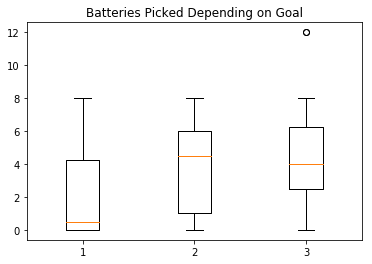

In [9]:
scores1=np.array(scores1)
scores2=np.array(scores2)
scores3=np.array(scores3)
battery_scores = [s[:,3] for s in [scores1, scores2, scores3]]
plt.boxplot(battery_scores)
plt.title("Batteries Picked Depending on Goal")
#xticks(np.arange(3), ('NotBatt', 'Battery', 'Battery'))
plt.show()



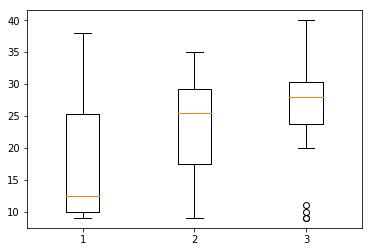

In [10]:
food_scores = [s[:,2] for s in [scores1, scores2, scores3]]
plt.boxplot(food_scores)
plt.show()
#All food seekers. NotBatt, Batt, Batt

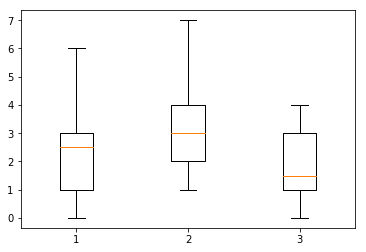

In [12]:
poison_scores = [s[:,1] for s in [scores1, scores2, scores3]]
plt.boxplot(poison_scores)
plt.show()

#Zero,zero, minusOne. Notbatt, Batt,Batt

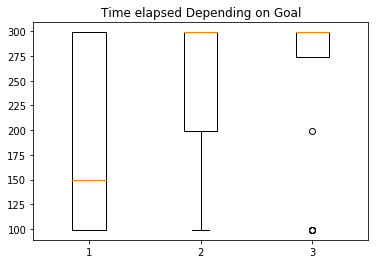

In [8]:
scores1=np.array(scores1)
scores2=np.array(scores2)
scores3=np.array(scores3)
battery_scores = [s[:,4] for s in [scores1, scores2, scores3]]
plt.boxplot(battery_scores)
plt.title("Time elapsed Depending on Goal")
#xticks(np.arange(3), ('NotBatt', 'Battery', 'Battery'))
plt.show()

